In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 450kB 43.6MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 3.9MB 37.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=e8292a9b00eab3ab83a3af6e932d9b1fcfe5ffdb55f775242202c2560012bef9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probabilit

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_path = '/content/drive/MyDrive/cats_vs_dogs_ds/train'
valid_path = '/content/drive/MyDrive/valid'
test_path = '/content/drive/MyDrive/cats_vs_dogs_ds/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path,target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

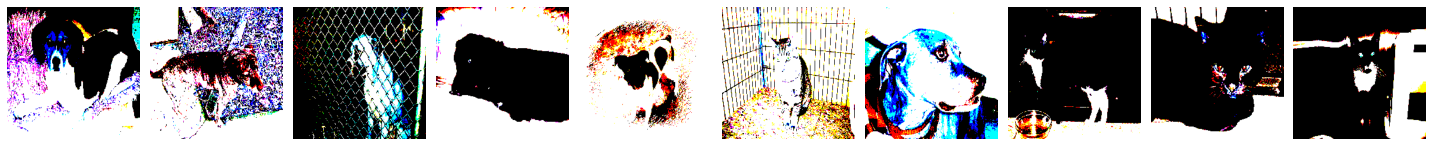

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [7]:
imags, labs = next(train_batches)
plotImages(imags)
print(labs)

In [8]:
# One-hot encoding
# [1,0] represents cat
# [0,1] represents dog

In [9]:
# ImageDataGenerator returns a sequence or a directory iterator. We need to pass another parameter to the fit function whenever our data is stored in a inifinitely repeating dataset
# we need to specift the steps_per_epoch = no. of batches of samples, to yield from the dataset, before declaring one epoch complete, else model.fir() will run infinitely.

In [10]:
model = Sequential([
  Conv2D(filters=32, kernel_size=(3,3),activation='relu', padding='same', input_shape=(224,224,3)),
  MaxPool2D(pool_size=(2,2), strides=2),
  Conv2D(filters=64,kernel_size=(3,3), activation='relu', padding='same'),
  MaxPool2D(pool_size=(2,2), strides=2),
  Flatten(),
  Dense(units=2, activation='softmax'),
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) # binary crossentropy can also be used

In [15]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 - 87s - loss: 2.9572 - accuracy: 0.7290 - val_loss: 3.8879 - val_accuracy: 0.6400
Epoch 2/10
100/100 - 77s - loss: 0.6411 - accuracy: 0.8890 - val_loss: 4.1105 - val_accuracy: 0.6050
Epoch 3/10
100/100 - 72s - loss: 0.3898 - accuracy: 0.9200 - val_loss: 3.1392 - val_accuracy: 0.6650
Epoch 4/10
100/100 - 75s - loss: 0.0375 - accuracy: 0.9890 - val_loss: 2.8574 - val_accuracy: 0.6600
Epoch 5/10
100/100 - 72s - loss: 0.0130 - accuracy: 0.9930 - val_loss: 2.9251 - val_accuracy: 0.6500
Epoch 6/10
100/100 - 72s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 3.0712 - val_accuracy: 0.6650
Epoch 7/10
100/100 - 72s - loss: 6.3781e-04 - accuracy: 1.0000 - val_loss: 3.1420 - val_accuracy: 0.6450
Epoch 8/10
100/100 - 72s - loss: 4.1935e-04 - accuracy: 1.0000 - val_loss: 3.1175 - val_accuracy: 0.6500
Epoch 9/10
100/100 - 72s - loss: 3.4474e-04 - accuracy: 1.0000 - val_loss: 3.1225 - val_acc

In [16]:
# As we can see the model suffers from overfitting

# For now we will see the fine tuning in the image

In [17]:
# Build Fine tuned VGG16 model

In [10]:
vgg16_model = tf.keras.applications.VGG16()

553467904/553467096 [==============================] - 12s 0us/step


In [22]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [25]:
for layer in model.layers:
  layer.trainable = False

In [26]:
model.add(Dense(units=2,activation='softmax'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [28]:
# train the fine tune VGG16 model

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 20 steps
Epoch 1/5
100/100 - 632s - loss: 0.2226 - accuracy: 0.9090 - val_loss: 0.0717 - val_accuracy: 0.9700
Epoch 2/5
100/100 - 630s - loss: 0.0658 - accuracy: 0.9780 - val_loss: 0.0528 - val_accuracy: 0.9800
Epoch 3/5
100/100 - 630s - loss: 0.0443 - accuracy: 0.9890 - val_loss: 0.0512 - val_accuracy: 0.9800
Epoch 4/5
100/100 - 632s - loss: 0.0311 - accuracy: 0.9940 - val_loss: 0.0474 - val_accuracy: 0.9800
Epoch 5/5
100/100 - 630s - loss: 0.0238 - accuracy: 0.9950 - val_loss: 0.0470 - val_accuracy: 0.9750


In [31]:
# Make predictions

In [32]:
predictions = model.predict(x=test_batches, verbose=0)

In [34]:
import numpy as np

cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions, axis=-1))

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[48  2]
 [ 2 48]]


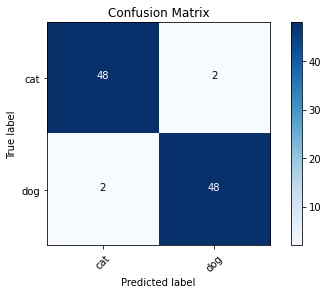

In [37]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')